# Keras_CIFAR10_CNN_简单模型
**正确率为0.7065**

## 导入模块

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from functools import partial
from sklearn.preprocessing import normalize

from keras import backend
from keras.utils import np_utils
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Input
from keras.layers import Activation, Dropout, Flatten, BatchNormalization

np.random.seed(42)

Using TensorFlow backend.


## 准备数据

In [2]:
filepath = r"I:\Dataset\CIFAR\cifar-10-batches-py"
files = os.listdir(filepath)

for fn in files:
    fp = os.path.join(filepath, fn)
    f = open(fp, 'rb')
    if "1" in fn:
        data_b = pickle.load(f, encoding="bytes")
        y_train = np_utils.to_categorical(data_b[b"labels"])
        X_train = np.array(data_b[b"data"])
    if "data" in fn and "1" not in fn:
        data_b = pickle.load(f, encoding="bytes")
        imgs = np.array(data_b[b"data"])
        t_1hot = np_utils.to_categorical(data_b[b"labels"])
        y_train = np.vstack((y_train, t_1hot))
        X_train = np.vstack((X_train, imgs))
    elif "meta" in fn:
        meta = pickle.load(f, encoding="bytes")
        label_dict = [label.decode() for label in meta[b"label_names"]]
    elif "test" in fn:
        test_b = pickle.load(f, encoding="bytes")
        X_test = test_b[b"data"]
        labels = test_b[b"labels"]
        y_test = np_utils.to_categorical(labels)
    f.close()

"""规范化数据以及切分训练集、验证集和测试集"""
X_train = normalize(X_train, axis=0, norm="max")
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
X_test = normalize(X_test, axis=0, norm="max")
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
x_train = X_train[10000:]
t_train = y_train[10000:]
x_val   = X_train[:10000]
t_val   = y_train[:10000]

print("all files : \n", files)
print("\nall labels : \n", label_dict)
print("\nimgs   of trainset : ", x_train.shape)
print("labels of trainset : ", t_train.shape)
print("imgs   of   valset : ", x_val.shape)
print("labels of   valset : ", t_val.shape)
print("imgs   of  testset : ", X_test.shape)
print("labels of  testset : ", y_test.shape)

all files : 
 ['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']

all labels : 
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

imgs   of trainset :  (40000, 32, 32, 3)
labels of trainset :  (40000, 10)
imgs   of   valset :  (10000, 32, 32, 3)
labels of   valset :  (10000, 10)
imgs   of  testset :  (10000, 32, 32, 3)
labels of  testset :  (10000, 10)


## 分配计算资源

In [3]:
"""分配对应的计算资源"""
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
backend.set_session(sess)

## 定义模型

In [4]:
def myCNN():
    """定义CNN模型"""
    MyConv = partial(Conv2D, kernel_size=(3, 3), padding="same", activation="relu")
    MyMaxPool = partial(MaxPool2D, pool_size=(2, 2))
    
    cifar_input = Input(shape=(32, 32, 3), name="input")
    
    conv1 = MyConv(32, name="conv1")(cifar_input)
    conv2 = MyConv(32, name="conv2")(conv1)
    pool1 = MyMaxPool(name="pool1")(conv2)
    
    conv3 = MyConv(64, name="conv3")(pool1)
    conv4 = MyConv(64, name="conv4")(conv3)
    pool2 = MyMaxPool(name="pool2")(conv4)
    
    flat1 = Flatten()(pool2)    
    dense1 = Dense(512, activation="relu", name="dense1")(flat1)
    y_output = Dense(10, activation="softmax", name="output")(dense1)
    
    model = Model(inputs=cifar_input, outputs=y_output)
    return model
model = myCNN()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

## 训练模型

In [5]:
"""训练模型并保存模型及训练历史
保存模型单独创建一个子文件夹modeldir, 保存训练历史则为单个文件hisfile"""

models_name = "Keras_CIFAR10_CNN_" # 模型名称的公共前缀
factor_list = ["first_model"] # 此次调参的变量列表
model_list = []      # 模型名称列表
for i in range(len(factor_list)):
    modelname = models_name + factor_list[i] + ".h5"
    model_list.append(modelname)

# 创建模型保存子目录modeldir
if not os.path.isdir("saved_model"): 
    os.mkdir("saved_model")
modeldir = r"saved_model\first_model"
if not os.path.isdir(modeldir):
        os.mkdir(modeldir)

# 创建训练历史保存目录
if not os.path.isdir("train_history"): 
    os.mkdir("train_history")
# 设置训练历史文件路径
hisfile = r"train_history\Keras_CIFAR10_CNN_first_model.train_history" 
# 每个模型及其对应的训练历史作为键值对{modelname: train_history}
# train_history为字典，含四个key，代表train和val的loss和acc
model_train_history = dict() 

epochs=100
steps_per_epoch=300
for i in range(len(model_list)):
    model = myCNN()
    modelname = model_list[i]
    modelpath = os.path.join(modeldir, modelname)    
    
    train_his = np.array([]).reshape(-1, 2)
    val_his = np.array([]).reshape(-1, 2)
    
    datagen = ImageDataGenerator()
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(),
                  metrics=["accuracy"])
    print("\ntraining model : ", modelname)
    ck_epoch, max_val_acc = 0, 0.0
    for epoch in range(epochs+1):
        i = 0
        tr_his = []
        for X, y in datagen.flow(x_train, t_train, batch_size=32):
            his = model.train_on_batch(X, y)
            tr_his.append(his)
            i += 1
            if i >= steps_per_epoch: break
        tr = np.mean(tr_his, axis=0)
        val = model.evaluate(x_val, t_val, verbose=0)
        train_his = np.vstack((train_his, tr))
        val_his = np.vstack((val_his, val))
        
        if epoch%5==0:
            print("%4d epoch: train acc: %8f loss: %8f      val acc: %8f loss: %8f"%(epoch, tr[1], tr[0], val[1], val[0]))
        # 设置保存模型
        if val[1] > max_val_acc: 
            model.save(modelpath)
            ck_epoch = epoch
        # 提前停止
        if epoch-ck_epoch >30: 
            print("Early stop !")
            break  
    model_train_history[modelname] = {"acc": train_his[:, 1], "val_acc": val_his[:, 1],
                                      "loss": train_his[:, 0], "val_loss": val_his[:, 0]}


"""保存训练历史"""
fo = open(hisfile, 'wb')
pickle.dump(model_train_history, fo)
fo.close() 


training model :  Keras_CIFAR10_CNN_first_model.h5
   0 epoch: train acc: 0.325729 loss: 1.805888      val acc: 0.438400 loss: 1.531783
   5 epoch: train acc: 0.694375 loss: 0.870360      val acc: 0.671800 loss: 0.915440
  10 epoch: train acc: 0.797396 loss: 0.588052      val acc: 0.718800 loss: 0.822811
  15 epoch: train acc: 0.876979 loss: 0.378251      val acc: 0.729100 loss: 0.897379
  20 epoch: train acc: 0.924375 loss: 0.229561      val acc: 0.731200 loss: 1.041291
  25 epoch: train acc: 0.949375 loss: 0.159498      val acc: 0.713600 loss: 1.256576
  30 epoch: train acc: 0.961771 loss: 0.117761      val acc: 0.726700 loss: 1.319209
  35 epoch: train acc: 0.969063 loss: 0.092380      val acc: 0.730700 loss: 1.408157
  40 epoch: train acc: 0.972188 loss: 0.087017      val acc: 0.719700 loss: 1.483959
  45 epoch: train acc: 0.974688 loss: 0.080768      val acc: 0.724800 loss: 1.548809
  50 epoch: train acc: 0.982500 loss: 0.054352      val acc: 0.729300 loss: 1.724206
  55 epoch: t

## 可视化训练过程

In [16]:
def show_train_history(saved_history, his_img_file):  
    modelnames = sorted(list(saved_history.keys()))
    train = ["acc", "loss"]
    val = ["val_acc", "val_loss"]
    
    """作loss和acc两个图"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    color_add = 0.9/len(saved_history)
    for i in range(2):
        c = 0.05
        for j in range(len(saved_history)):
            modelname = modelnames[j]
            train_history = saved_history[modelname]
            ax[i].plot(train_history[train[i]], 
                       color=(0, 1-c, 0),
                       linestyle="-",
                       label="train_"+train[i])
            ax[i].plot(train_history[val[i]], 
                       color=(c, 0, 1-c),
                       linestyle="-",
                       label="val_"+train[i])
            c += color_add
        ax[i].set_ylabel(train[i], size=20)  
        ax[i].set_xlabel('Epoch', size=20)  
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right") 
#     ax[0].set_ylim(0.6, 1.0)
    plt.suptitle("CNN_simple Train History")
    print("saved img: ", his_img_file)
    plt.savefig(his_img_file)
    plt.show()

In [4]:
hisfile = r"train_history\Keras_CIFAR10_CNN_first_model.train_history" 

saved img:  his_img\CNN_simple.png


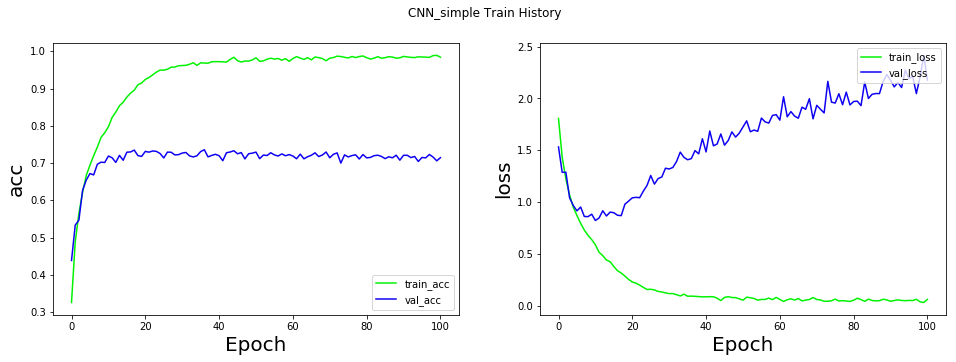

In [17]:
"""载入训练历史并可视化"""
fo2 = open(hisfile, "rb")
saved_history = pickle.load(fo2)

if not os.path.isdir("his_img"):
    os.mkdir("his_img")
his_img_file = r"his_img\CNN_simple.png"
show_train_history(saved_history, his_img_file)

## 用测试集测试模型

In [8]:
for modelname in model_list:
    modelpath = os.path.join(modeldir, modelname)
    smodel = load_model(modelpath)
    
    print("\ntest model : ", modelname)
    loss, acc = smodel.evaluate(X_test, y_test)    
    print("acc: %.4f \t loss: %.4f"%(acc, loss))


test model :  Keras_CIFAR10_CNN_first_model.h5
10000/10000 [==============================] - 3s 346us/step
acc: 0.7065 	 loss: 2.2663
